In [1]:
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import math
import time
import cv2
import os

from scipy.interpolate import interp1d
from itertools import permutations
from helper import *
from IPython.display import HTML
from glob import glob

import warnings
warnings.filterwarnings("ignore")

## Loading the data and plotting the EP6 map with the Pi's location on it

In [2]:
BLE_raw_dataset = pd.read_csv('BLE_raw_dataset.csv')
BLE_raw_dataset

,Unnamed: 0,Time,ID,RSSI,PI
0,0,1.702037e+09,dd:03:16:54:f4:d0,-82,133
1,1,1.702037e+09,dd:03:16:54:f4:d0,-82,133
2,2,1.702037e+09,dd:03:16:54:f4:d0,-82,163
3,3,1.702037e+09,dd:03:16:54:f4:d0,-76,163
4,4,1.702037e+09,dd:03:16:54:f4:d0,-78,163
...,...,...,...,...,...
7145,7145,1.702078e+09,dd:03:16:54:f4:d0,-77,107
7146,7146,1.702078e+09,dd:03:16:54:f4:d0,-77,107
7147,7147,1.702078e+09,dd:03:16:54:f4:d0,-85,107
7148,7148,1.702078e+09,dd:03:16:54:f4:d0,-80,107


In [3]:
date = '2023/12/8'
sTime = "17:47:00"
eTime = "17:49:00"

dataframe = locator('BLE_raw_dataset', date, sTime,eTime)
dfp = dataframe.copy()
dfp

,location,rooms,time,PI,#Hits
0,"(1160, 699)",RC,1702075643,[133],[1]
1,"(1168, 918)",RC,1702075645,[118],[1]
2,"(1168, 918)",RC,1702075646,[118],[1]
3,"(1168, 918)",RC,1702075647,[118],[1]
4,"(1168, 918)",RC,1702075648,[118],[1]
...,...,...,...,...,...
93,"(1164, 170)",Kitchen,1702075737,[101],[1]
94,"(1164, 170)",Kitchen,1702075738,[101],[1]
95,"(1164, 170)",Kitchen,1702075739,[101],[1]
96,"(1164, 170)",Kitchen,1702075740,[101],[1]


## Plotting the EP6 floormap and the location of the Pis

1830x1167


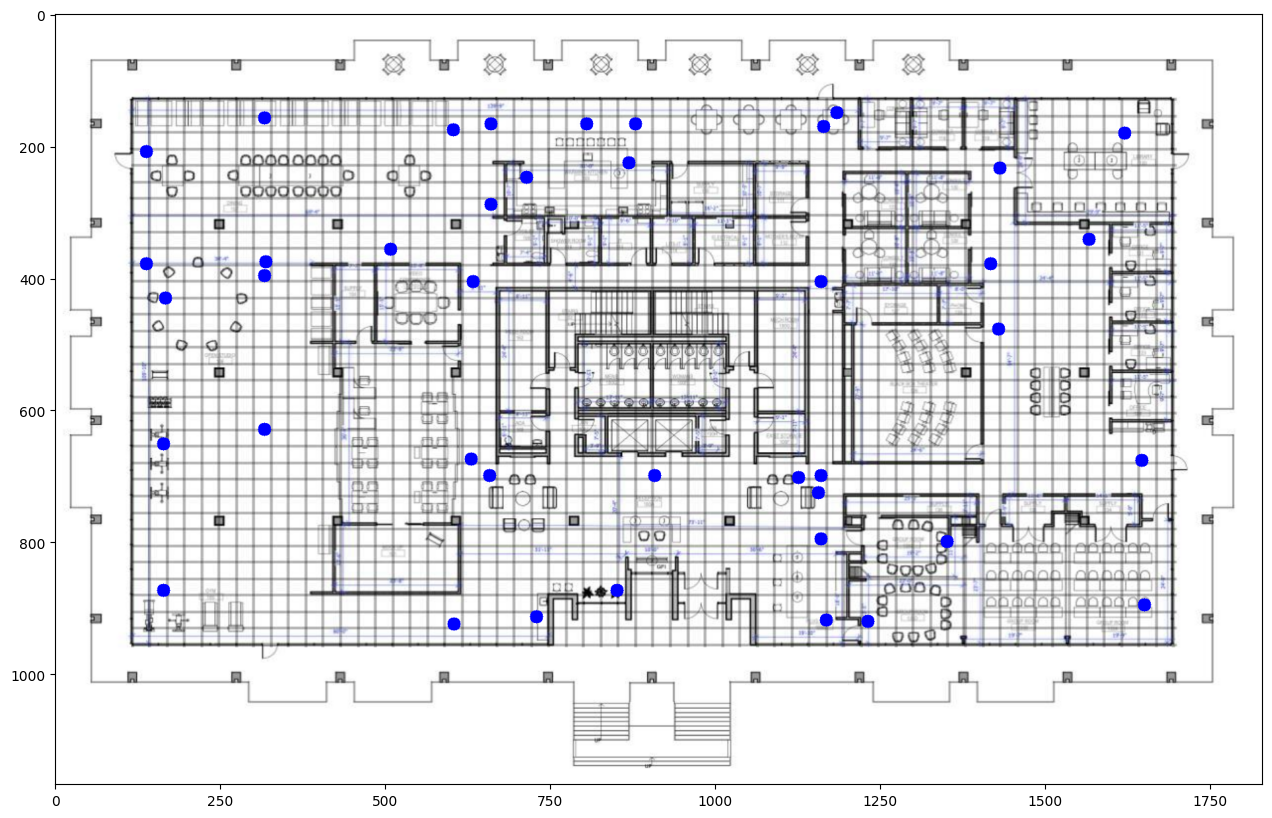

In [4]:
# Loading Pi X and Y Locations on Map
locations = np.loadtxt('PiLocations.csv', delimiter = ',', dtype = {'names': ('Pi', 'X', 'Y'),'formats': ('i','i','i')}, skiprows = 1)
Locations = {}

Pi, X, Y = [], [], []

for location in locations:
    Pi.append(location[0])
    X.append(location[1])
    Y.append(location[2])
    
    
data = {'Pi': Pi, 'X': X, 'Y': Y}
df = pd.DataFrame(data)

img = cv2.imread("ep6_floorplan_measured_half_gridded_1_meter.jpg", cv2.IMREAD_COLOR)
img = cv2.resize(img, (610*3, 389*3))

wid = img.shape[1]
hgt = img.shape[0]

print(str(wid) + "x" + str(hgt))

color=[0,0,255] 

for i in range(0, len(df)):
    
    image = cv2.circle(img, (int(df['X'][i] * 1830/2432), int(df['Y'][i] * 1167/1632)), 10, color , -1)

plt.figure(figsize=(20,10))
plt.imshow(image)

## Adding the ground truth data to this map

,X,Y,T
0,1170,925,5
1,1170,873,10
2,1170,821,15
3,1170,769,20
4,1170,717,25
5,1170,665,30
6,1170,613,35
7,1170,561,40
8,1170,509,45
9,1170,457,50


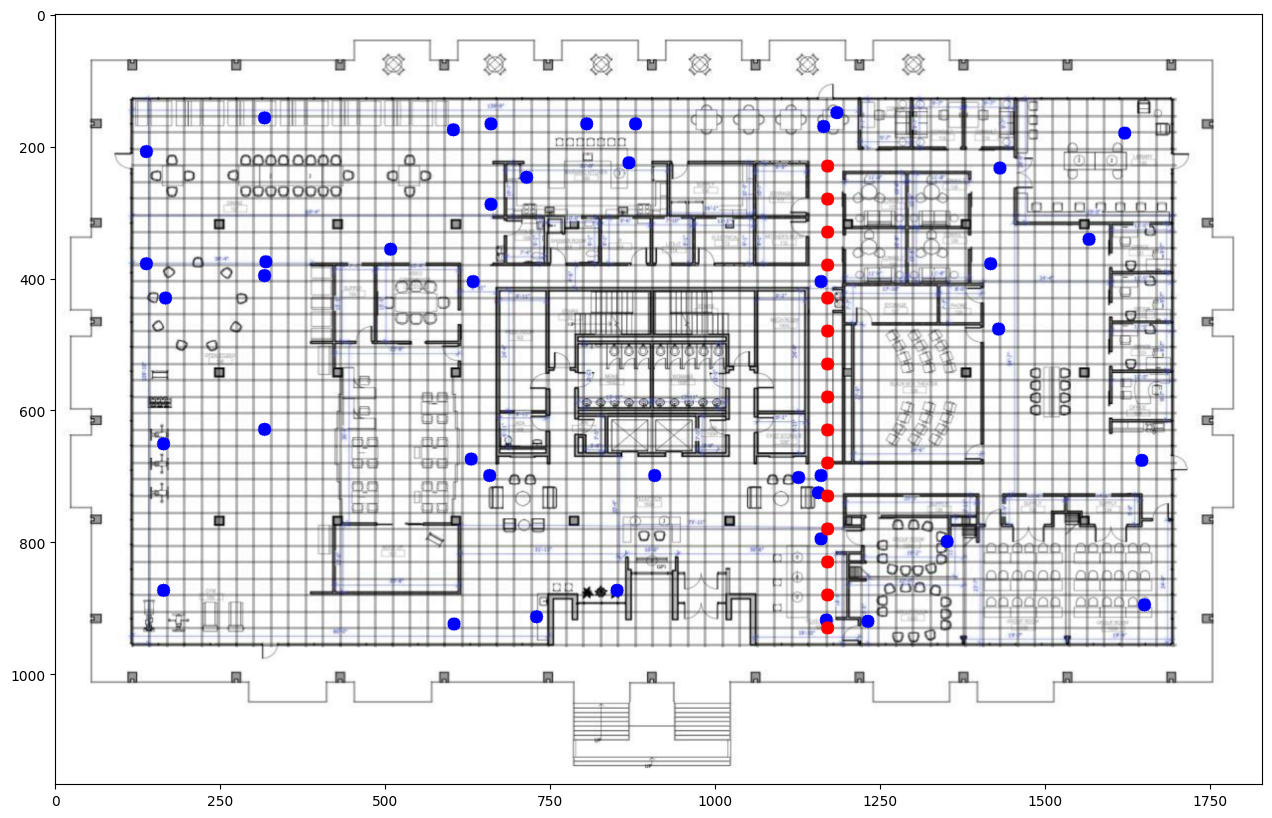

In [5]:
# ## RC real data

color=[255, 0, 0] 

X, Y, T = [], [], []

for i in range(0, 15):
    
    image = cv2.circle(image, (1170, 930 - i*50), 10, color , -1)
    X.append(1170)
    Y.append(925 - i*52)
    T.append(5 + i*5)

plt.figure(figsize=(20,10))
plt.imshow(image)

Ground_Truth = {'X': X, 'Y': Y, 'T': T}
df_GT = pd.DataFrame(Ground_Truth)
df_GT

In [6]:
color=[255,0,0] 

X, Y , R, T, NP, NH = [], [], [], [], [], []

for i in range(0,len(dfp['location'])):    

    X.append(dfp['location'][i][0])
    Y.append(dfp['location'][i][1]) 
    R.append(dfp['rooms'][i])
    T.append(dfp['time'][i])
            
data = {'X': X, 'Y': Y, 'R': R, 'T': T}
dfm = pd.DataFrame(data)  
time_list = dfm['T'] - dfm['T'][0]
dfm['T'] = np.array(time_list)
dfm

,X,Y,R,T
0,1160,699,RC,0
1,1168,918,RC,2
2,1168,918,RC,3
3,1168,918,RC,4
4,1168,918,RC,5
...,...,...,...,...
93,1164,170,Kitchen,94
94,1164,170,Kitchen,95
95,1164,170,Kitchen,96
96,1164,170,Kitchen,97


In [7]:
XA, YA, T = [], [], []

inner_counter = 0

for i in range(1,len(df_GT)):

    if len(dfm)>=len(df_GT):

        dynamic_interval = np.floor(len(dfm)/len(df_GT))
        dfm_reduced = dfm[int((i-1)*dynamic_interval):int(i*dynamic_interval)]
    
        if len(dfm_reduced) != 0:
            XA.append(dfm_reduced['X'].mean())
            YA.append(dfm_reduced['Y'].mean())
        else:
            XA.append(XA[-1])
            YA.append(YA[-1])
            
        T.append(i*dynamic_interval)
       
    else:

        dynamic_interval = np.ceil(len(df_GT)/len(dfm))
        
        counter = 0
    
        while counter < dynamic_interval:
            
            XA.append(dfm['X'][inner_counter])
            YA.append(dfm['Y'][inner_counter])
            T.append(dfm['T'][inner_counter])
            counter = counter + 1

        inner_counter = inner_counter + 1
        
        # print(inner_counter)
        if inner_counter >= len(dfm):
            break
        

if len(dfm)>=len(df_GT):
    
    print(dfm.iloc[-2:])
    XA.append(dfm['X'].iloc[-2:].mean())
    YA.append(dfm['Y'].iloc[-2:].mean())
    T.append((i+1)*dynamic_interval)

else:
    print('dfm legnth was smaller')
 
data = {'X': XA, 'Y': YA, 'T': T}
dfp = pd.DataFrame(data)
dfp

       X    Y        R   T
96  1164  170  Kitchen  97
97  1164  170  Kitchen  98


,X,Y,T
0,1166.666667,881.500000,6.0
1,1166.666667,881.500000,12.0
2,1160.666667,717.333333,18.0
3,1163.333333,790.666667,24.0
4,1160.000000,699.000000,30.0
5,1160.000000,731.000000,36.0
6,1160.000000,731.000000,42.0
7,1160.000000,454.000000,48.0
8,1160.000000,405.000000,54.0
9,1160.000000,405.000000,60.0


## Figure 2

len dfp was not greater than len dfm


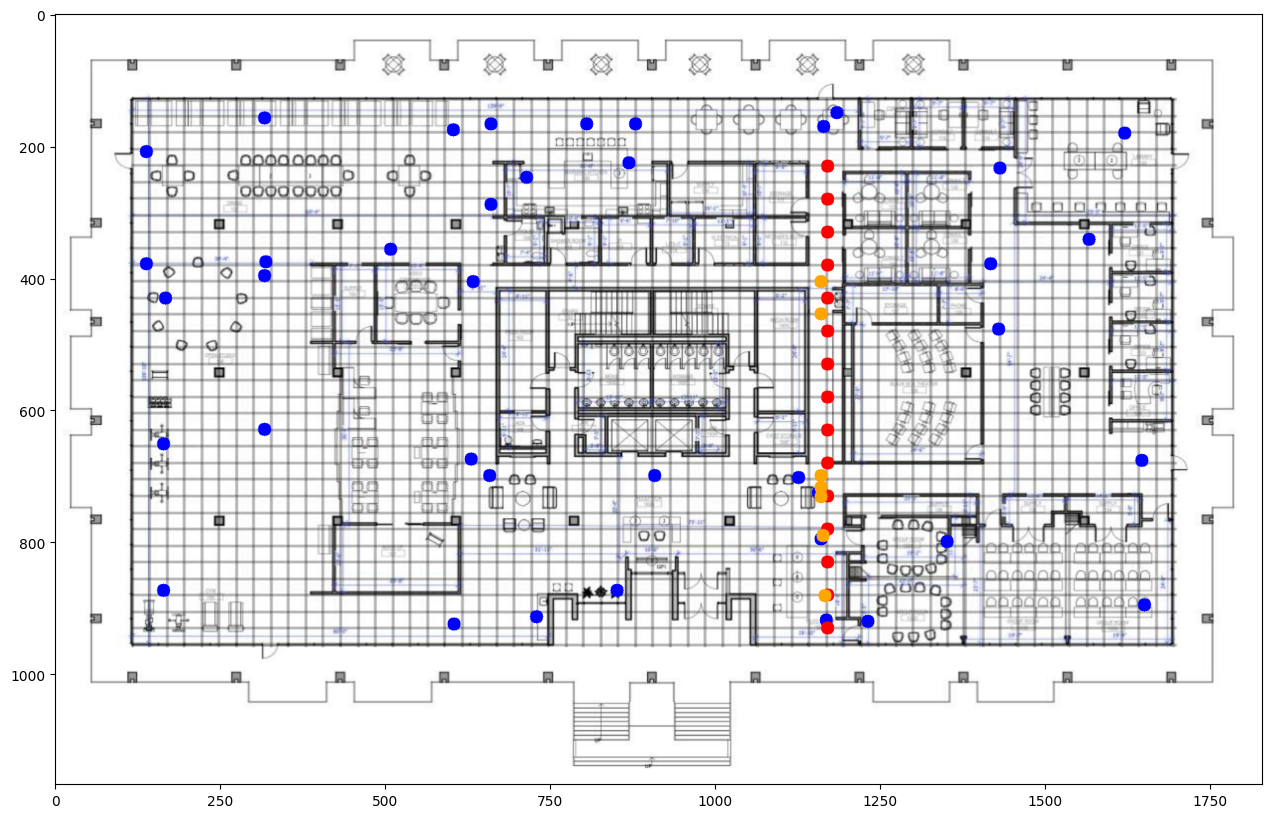

In [8]:
dfm = dfp.copy()

if len(dfm) > len(df_GT):

    XA, YA, T = [], [], []

    dynamic_interval = np.floor(len(dfm)/len(df_GT))
    
    for i in range(1,len(df_GT)):
    
        print(i)
        dfm_reduced = dfm[int((i-1)*dynamic_interval):int(i*dynamic_interval)]
        print(dfm_reduced)
    
        if len(dfm_reduced) != 0:
            XA.append(dfm_reduced['X'].mean())
            YA.append(dfm_reduced['Y'].mean())
        else:
            XA.append(XA[-1])
            YA.append(YA[-1])
            
        T.append(i*dynamic_interval)
    
    print(dfm.iloc[-2:])
    XA.append(dfm['X'].iloc[-2:].mean())
    YA.append(dfm['Y'].iloc[-2:].mean())
    T.append((i+1)*dynamic_interval)
    
    
    data = {'X': XA, 'Y': YA, 'T': T}
    dfp = pd.DataFrame(data)
    dfp

else:

    print('len dfp was not greater than len dfm')


color = [255, 165, 0]

for i in range(0,len(dfp)-1):

    image_new = cv2.circle(image, (int(dfp['X'][i]),int(dfp['Y'][i])), 10, color, -1)
    # image_new = cv2.arrowedLine(image_new, (int(dfm['X'][i]),int(dfm['Y'][i])), (int(dfm['X'][i+1]),int(dfm['Y'][i+1])), color, 2,tipLength = 0.001)
#     image_new = cv2.putText(img, str(i), (int(dfm['X'][i]), int(dfm['Y'][i])), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2, cv2.LINE_AA)


plt.figure(figsize=(20, 10))
plt.imshow(image_new)

In [9]:
Err_RG = []

for i in range(0, len(df_GT)):
    Err_RG.append(computeDistance((dfp['X'][i], dfp['Y'][i]), (df_GT['X'][i], df_GT['Y'][i])))

Err_RG_scalded = [x * 33.4772/(955 - 130) for x in Err_RG] # Change it into the meter
AveErr = np.mean(Err_RG_scalded)
StdErr = np.std(Err_RG_scalded)
print(AveErr)

2.709530645139868


In [10]:
X_G = df_GT['X'].tolist()
Y_G = df_GT['Y'].tolist()

X_P = dfp['X'].tolist()
Y_P = dfp['Y'].tolist()

data = {'XG': X_G, 'YG': Y_G, 'XP': X_P, 'YP': Y_P, 'Err': Err_RG_scalded}
dft = pd.DataFrame(data)
dft

,XG,YG,XP,YP,Err
0,1170,925,1166.666667,881.500000,1.770336
1,1170,873,1166.666667,881.500000,0.370490
2,1170,821,1160.666667,717.333333,4.223645
3,1170,769,1163.333333,790.666667,0.919877
4,1170,717,1160.000000,699.000000,0.835561
5,1170,665,1160.000000,731.000000,2.708743
6,1170,613,1160.000000,731.000000,4.805418
7,1170,561,1160.000000,454.000000,4.360812
8,1170,509,1160.000000,405.000000,4.239620
9,1170,457,1160.000000,405.000000,2.148742


In [11]:
df_ind = pd.read_pickle('locationwise_error_one_by_one.pkl')
df = df_ind

In [12]:
df

,dft1,dft2,dft3,dft4,dft5,dft6,dft7
0,21.104682,0.295415,9.179697,9.179697,6.262238,9.185714,1.770336
1,18.995037,1.827832,7.072297,7.072297,4.166606,7.164936,0.370490
2,16.885501,3.936944,4.967170,3.755204,5.002270,4.991146,4.223645
3,14.776119,6.046730,2.869328,2.869328,8.814863,2.968888,0.919877
4,12.666970,8.156667,2.141107,0.921908,0.835561,1.273542,0.835561
5,10.558191,10.266662,1.788548,4.530530,1.438103,1.826029,2.708743
6,8.450061,12.376685,5.101250,5.493096,3.513257,3.735199,4.805418
7,6.343227,14.486725,6.910257,7.599007,5.614506,5.785664,4.360812
8,4.239620,8.032581,11.093450,1.492690,4.744770,0.671556,4.239620
9,2.148742,10.100768,8.450061,2.148742,2.148742,2.148742,2.148742


In [13]:
df.columns = [f'BLE-{i}' for i in range(1, 8)]
df

,BLE-1,BLE-2,BLE-3,BLE-4,BLE-5,BLE-6,BLE-7
0,21.104682,0.295415,9.179697,9.179697,6.262238,9.185714,1.770336
1,18.995037,1.827832,7.072297,7.072297,4.166606,7.164936,0.370490
2,16.885501,3.936944,4.967170,3.755204,5.002270,4.991146,4.223645
3,14.776119,6.046730,2.869328,2.869328,8.814863,2.968888,0.919877
4,12.666970,8.156667,2.141107,0.921908,0.835561,1.273542,0.835561
5,10.558191,10.266662,1.788548,4.530530,1.438103,1.826029,2.708743
6,8.450061,12.376685,5.101250,5.493096,3.513257,3.735199,4.805418
7,6.343227,14.486725,6.910257,7.599007,5.614506,5.785664,4.360812
8,4.239620,8.032581,11.093450,1.492690,4.744770,0.671556,4.239620
9,2.148742,10.100768,8.450061,2.148742,2.148742,2.148742,2.148742


## Figure 7

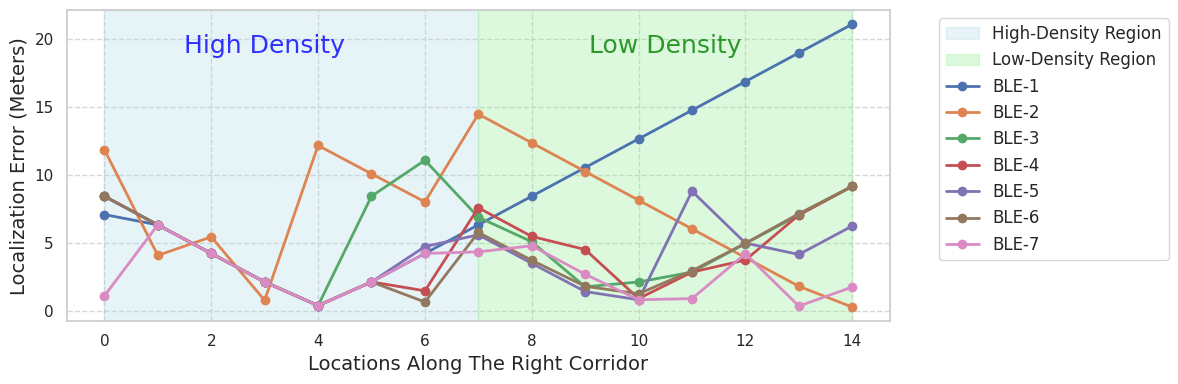

In [14]:
# Set a modern style
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 4))

# Define region boundaries
high_density_range = range(0, 8)  # First 7 indices
low_density_range = range(8, 15)  # Last 7 indices

# Add shaded regions
plt.axvspan(0, 7, color='lightblue', alpha=0.3, label='High-Density Region')
plt.axvspan(7, 14, color='lightgreen', alpha=0.3, label='Low-Density Region')

# Plot the lines
for column in df.columns:
    plt.plot(df[column][::-1].reset_index(drop=True), 
             '-o', 
             label=column, 
             linewidth=2, 
             markersize=6)

# Add labels, title, and legend
plt.xlabel('Locations Along The Right Corridor', fontsize=14)
plt.ylabel('Localization Error (Meters)', fontsize=14)
plt.title('', fontsize=16)

# Add a legend for both lines and regions
plt.legend(title='', fontsize=12, title_fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate the regions
plt.text(3, max(df.max()) * 0.9, 'High Density', fontsize=18, color='blue', ha='center', alpha=0.8)
plt.text(10.5, max(df.max()) * 0.9, 'Low Density', fontsize=18, color='green', ha='center', alpha=0.8)

# Adjust layout and grid
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.8)

plt.savefig('error_trends_by_region.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



## Figure 6

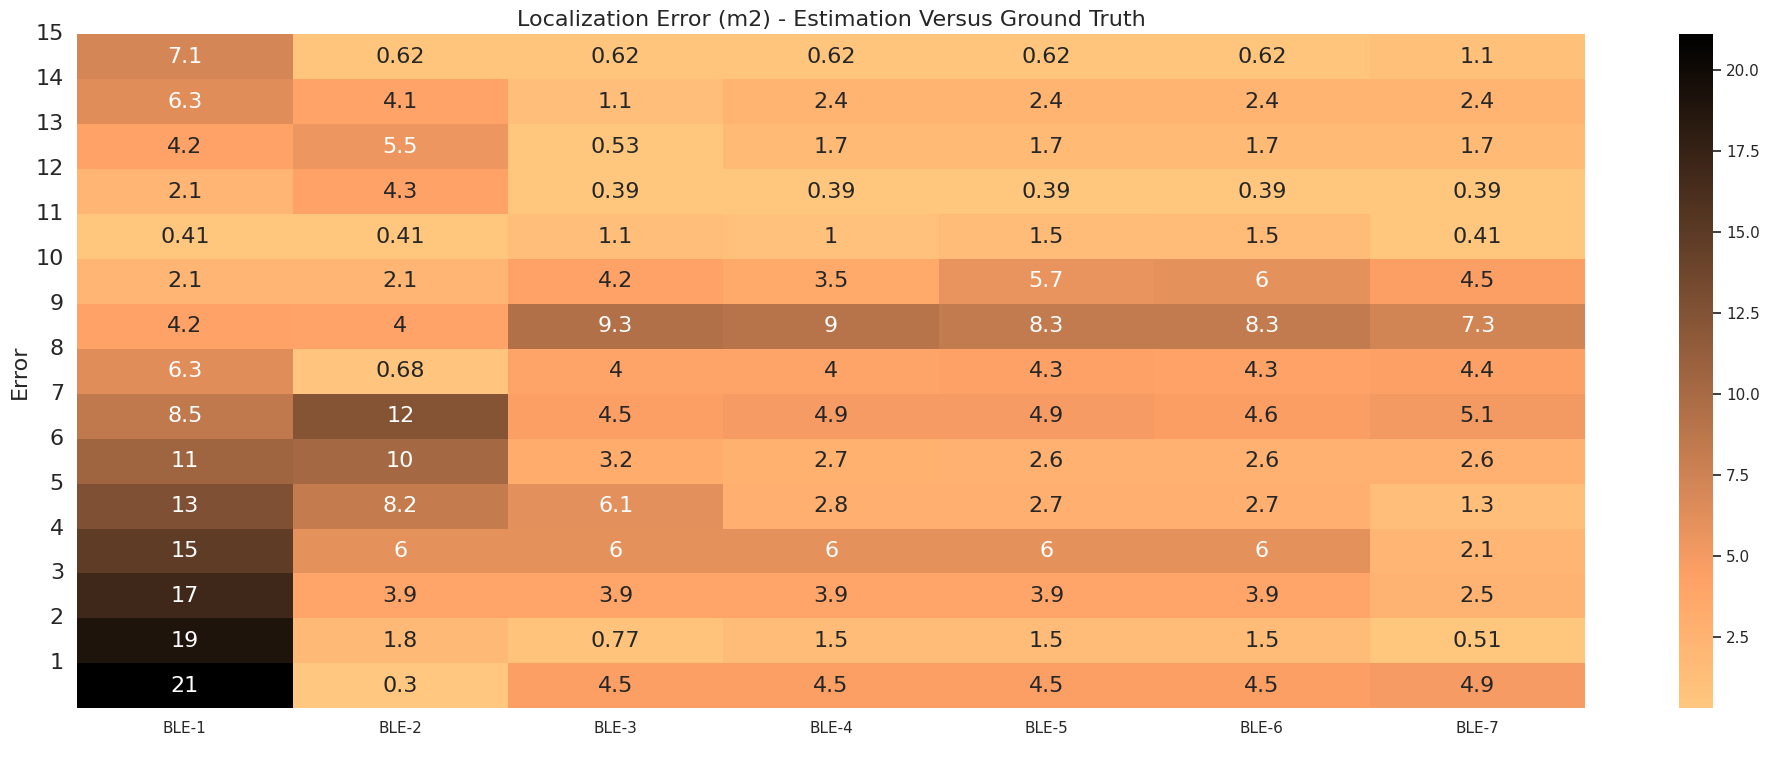

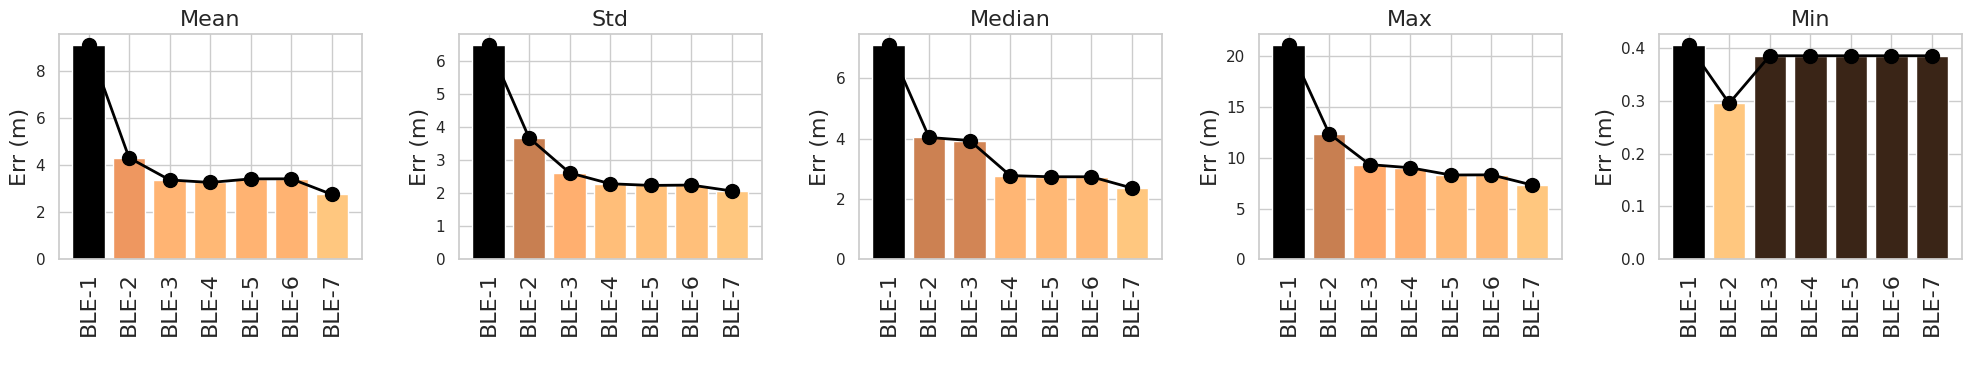

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the DataFrame (already done)
df_total = pd.read_pickle('locationwise_error.pkl')
df = df_total
# Rename columns
df.rename(columns={'dft1': 'BLE-1', 'dft2': 'BLE-2', 'dft3': 'BLE-3', 'dft4': 'BLE-4', 'dft5': 'BLE-5', 'dft6': 'BLE-6', 'dft7': 'BLE-7'}, inplace=True)

# Calculate statistics
df_stats = pd.DataFrame({
    'Mean': df.mean(),
    'Std': df.std(),
    'Median': df.median(),
    'Max': df.max(),
    'Min': df.min()
})

cmap = plt.cm.copper_r  # Define colormap

# Adjust font sizes globally
plt.rcParams.update({'font.size': 16})  # General font size for all elements

# First figure: Heatmap of the data
fig1, ax1 = plt.subplots(figsize=(20, 8))
sns.heatmap(df, annot=True, cmap=cmap, vmin=df.min().min(), vmax=df.max().max(), ax=ax1, annot_kws={'fontsize': 16})  # Increase annotation font size

# Reverse the y-axis and set y-ticks to start from 1
ax1.invert_yaxis()  # Reverse the y-axis
ax1.set_yticks(range(1, len(df.index) + 1))  # Set y-ticks to start from 1
ax1.set_yticklabels(range(1, len(df.index) + 1), fontsize=16, rotation=0)  # Make y-tick labels horizontal

ax1.set_title('Localization Error (m2) - Estimation Versus Ground Truth', fontsize=16)  # Increase title font size
ax1.set_xlabel(' ', fontsize=16)  # Increase x-axis label font size
ax1.set_ylabel('Error', fontsize=16)  # Increase y-axis label font size

plt.tight_layout()
plt.savefig('heatmap_of_df_columns.png')  # Save as PNG
plt.show()

# Set up the figure and axes for statistics bar plots
fig2, ax_array = plt.subplots(1, 5, figsize=(20, 4))

# Plot each statistic in its own subplot
for i, (stat, values) in enumerate(df_stats.items()):
    # Normalize values for color mapping
    norm = plt.Normalize(vmin=values.min(), vmax=values.max())
    colors = cmap(norm(values))  # Map colors based on values

    # Plot each bar with color mapping
    bars = ax_array[i].bar(values.index, values, color=colors)
    ax_array[i].set_title(stat, fontsize=16)  # Increase subplot title font size
    ax_array[i].set_ylabel('Err (m)', fontsize=16)  # Increase y-axis label font size
    ax_array[i].set_xlabel(' ', fontsize=16)  # Increase x-axis label font size

    # Overlay dot and line plots
    ax_array[i].plot(values.index, values, marker='o', color='black', linestyle='-', linewidth=2, markersize=10)

    # Set x-ticks to vertical position and increase font size
    ax_array[i].set_xticklabels(values.index, rotation=90, fontsize=16)  # Set rotation and font size for x-tick labels

# Tight layout and display
plt.tight_layout()
plt.savefig('statistics_bar_plots.png')  # Save as PNG
plt.show()


## Figure 4

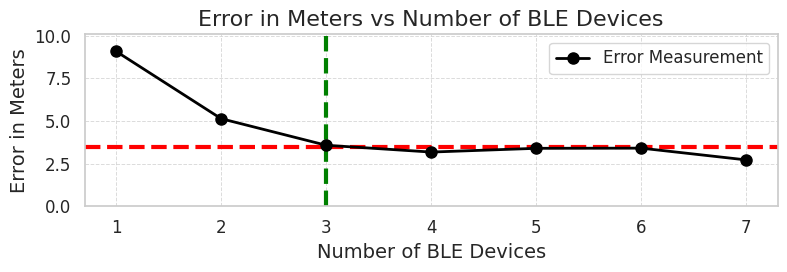

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
data = np.load("Figure_4_data.npy")

# Extract the first column and handle NaN values
first_column = [row[0] for row in data]

# Define the number of BLE devices (1 to 7 for this example)
ble_devices = list(range(1, len(first_column) + 1))

# Create a figure with a larger size
plt.figure(figsize=(8, 3))

# Add horizontal and vertical lines
plt.axhline(y=3.5, color='red', linestyle='--', linewidth=3)
plt.axvline(x=3, color='green', linestyle='--', linewidth=3)

# Plot the first column with enhanced styling
plt.plot(ble_devices, first_column, marker='o', color='black', markersize=8, linestyle='-', linewidth=2, label='Error Measurement')

# Set labels and title with larger font sizes
plt.xlabel('Number of BLE Devices', fontsize=14)
plt.ylabel('Error in Meters', fontsize=14)
plt.title('Error in Meters vs Number of BLE Devices', fontsize=16)

# Set x-ticks to match the number of BLE devices
plt.xticks(ble_devices, fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Set limits on the axes if necessary (adjust based on your data)
plt.ylim(0, max([val for val in first_column if not np.isnan(val)]) + 1)  # Set the y-limit based on your data

# Add a legend
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout for better

# Save the figure
plt.savefig('Error_in_Meters_vs_Number_of_BLE_Devices.png', dpi=300, bbox_inches='tight')  # Save as PNG with 300 DPI
plt.show()


## Figure 5

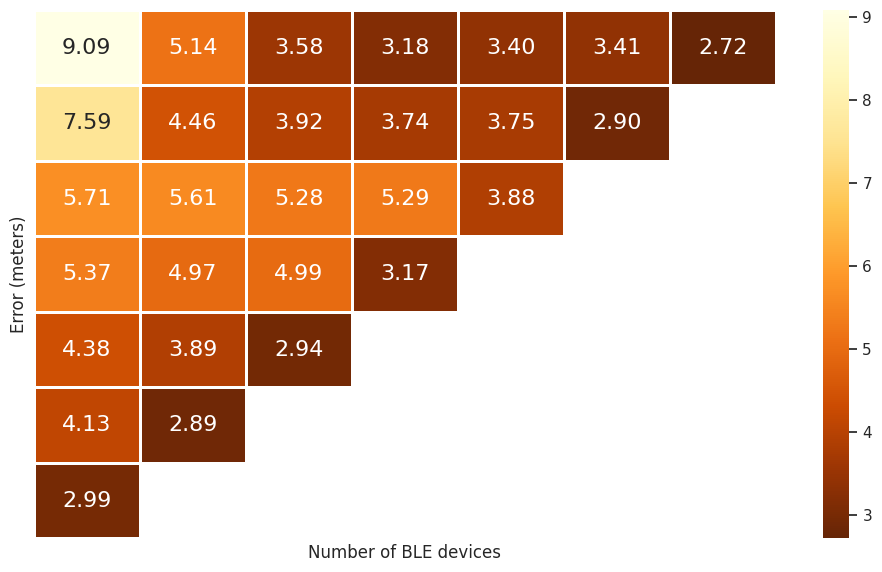

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
data = np.load("Figure_4_data.npy")

# Convert the data to a numpy array
data_array = np.array(data).T

# Create a heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(data_array, annot=True, fmt=".2f", cmap='YlOrBr_r', 
                 cbar=True, mask=np.isnan(data_array), linewidths=2, linecolor='white')

# Hide x-axis and y-axis
ax.set_xticks([])
ax.set_yticks([])

# Optionally hide axis labels if you want no labels at all
plt.xlabel('Number of BLE devices')
plt.ylabel('Error (meters)')

# Show the plot
plt.tight_layout()
plt.savefig('Heatmap_Error_in_Meters_vs_Number_of_BLE_Devices.png', dpi=300, bbox_inches='tight')  # Save as PNG with 300 DPI
plt.show()
